In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import display
from tqdm.notebook import tqdm
import sys
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.io import FixedLenFeature
from tensorflow.keras.applications.efficientnet import  EfficientNetB7

import matplotlib.pyplot as plt

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("Running on TPU:", resolver.master())

INFO:tensorflow:Initializing the TPU system: grpc://10.93.64.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.64.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.93.64.2:8470


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
project_id="inductive-choir-306607"
!gcloud config set project {project_id}
!gsutil ls gs://km_kaggle_catheter/

Updated property [core/project].
gs://km_kaggle_catheter/train_resized.tfrec


In [3]:
class CFG:
    debug=False

    dataset_dir="../input/ranzcr-clip-catheter-line-classification/"
    img_dir="../input/ranzcr_256x_256_png/"
    models_dir="./models/"

    target_size=(256,256)
    batch_size=4 if debug else 256
    epochs=10 if debug else 20

    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']

print(CFG.debug)

False


In [ ]:
feature_description={
    "CVC - Abnormal":FixedLenFeature([],tf.int64),
    "CVC - Borderline":FixedLenFeature([],tf.int64),
    "CVC - Normal":FixedLenFeature([],tf.int64),
    "ETT - Abnormal":FixedLenFeature([],tf.int64),
    "ETT - Borderline":FixedLenFeature([],tf.int64),
    "ETT - Normal":FixedLenFeature([],tf.int64),
    "NGT - Abnormal":FixedLenFeature([],tf.int64),
    "NGT - Borderline":FixedLenFeature([],tf.int64),
    "NGT - Incompletely Imaged":FixedLenFeature([],tf.int64),
    "NGT - Normal":FixedLenFeature([],tf.int64),
    "Swan Ganz Catheter Present":FixedLenFeature([],tf.int64),
    "StudyInstanceUID":FixedLenFeature([],tf.string),
    "image":FixedLenFeature([],tf.string),
}

def parse_examples(example):
    return tf.io.parse_example(example,feature_description)

In [ ]:
def preprocessing(parsed_record):
    image=tf.io.decode_png(parsed_record["image"],channels=3) # decode_imageではresizeでエラーが出る
    image=tf.cast(image,tf.float32)
    image=tf.reshape(image,[256,256,3]) # without this, TPU will not run
    image/=255.0 # normalization

    label=[]
    for col_name in CFG.target_cols:
        label.append(parsed_record[col_name])
    
    return image,label


def build_dataset(repeat=False):
    AUTO=tf.data.experimental.AUTOTUNE

    raw_dataset=tf.data.TFRecordDataset("gs://km_kaggle_catheter/train_resized.tfrec")
    dset=raw_dataset.map(parse_examples,num_parallel_calls=AUTO).cache() # apply time-consuming process before cache()
    dset=dset.map(preprocessing,num_parallel_calls=AUTO) # memory-consuming process should be placed after cache()
    dset=dset.repeat() if repeat else dset
    dset=dset.batch(CFG.batch_size).prefetch(AUTO) # Warning: putting preprocessing after batch() causes an error

    return dset

dset=build_dataset()

In [ ]:
def _bytes_feature(value):
    # valueがscalar tensorであった場合、内部のnumpyを明示的に呼ぶ
    if isinstance(value,type(tf.constant(0))):
        value=value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
%%time

train=pd.read_csv(f"{CFG.dataset_dir}train.csv")

def serialize_example(uid,image):
    uid_bytes=uid.encode()

    feature={
        "StudyInstanceUID":_bytes_feature(uid_bytes),
        "image":_bytes_feature(image)
    }

    target_series=train[train["StudyInstanceUID"]==uid]

    for col_name in CFG.target_cols:
        col_value=target_series[col_name].values[0]
        feature[col_name]=_int64_feature(col_value)
    
    example=tf.train.Example(features=tf.train.Features(feature=feature))

    return example.SerializeToString()

def write2tfrecord():
    recordname="../input/tfrecords_test.tfrec"
    with tf.io.TFRecordWriter(recordname) as writer:

        for path in tqdm(glob(CFG.img_dir+"*")):
            filename=os.path.basename(path)
            uid=os.path.splitext(filename)[0]

            image=tf.io.read_file(path)

            writer.write(serialize_example(uid,image))

NameError: name 'CFG' is not defined

In [ ]:
def image_show(image,title=None):
    fig,axes=plt.subplots(1,1,figsize=(5,5))
    axes.imshow(image)
    axes.axis(False)
    if title:
        axes.set_title(parsed_record["StudyInstanceUID"].numpy().decode())

In [ ]:
def save_png():
    for idx,filename in tqdm(enumerate(os.listdir("../input/ranzcr_256x_256_ndarray/"))):
        original_array=np.load(f"../input/ranzcr_256x_256_ndarray/{filename}")[0]
        png_bytes=tf.io.encode_png(original_array)
        uid=os.path.splitext(filename)[0]

        with open(f"{CFG.img_dir}{uid}.png","wb") as f:
            f.write(png_bytes.numpy())

0it [00:00, ?it/s]

tf.io.encode_png, tf.io.decode_pngによってndarrayを可逆的に圧縮できる  
復元されたndarrayは元と全く同じ

In [ ]:
def save_ndarrays():
    for record in tqdm(train_dataset):
        image,label,uid=record
        uid=uid.numpy()[0].decode()
        np.save(f"{CFG.img_dir}{uid}",image)

0it [00:00, ?it/s]

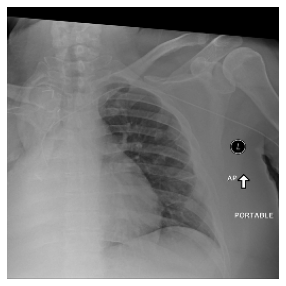

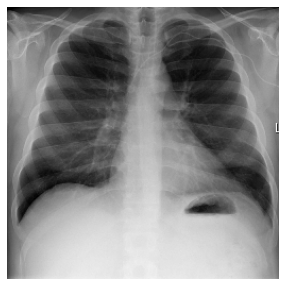

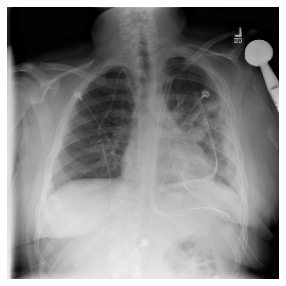

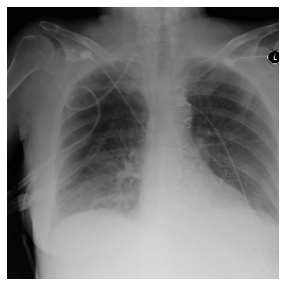

In [ ]:
for idx,path in enumerate(glob(CFG.img_dir+"*")):
    image=tf.io.read_file(path)
    image_array=tf.io.decode_png(image).numpy()
    uid=os.path.splitext(os.path.basename(path))[0]

    image_show(image_array)

    if idx==3:
        break

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/catheter/models/effnet_finetune/checkpoint", save_best_only=True, monitor="auc", mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="auc", patience=3, min_lr=1e-6, mode='max')

In [ ]:
with strategy.scope():
    effB7=EfficientNetB7(include_top=False,weights="imagenet",input_shape=(256,256,3),pooling="avg")

    model=keras.Sequential([
        effB7,
        keras.layers.Dense(11,activation="sigmoid")
    ])


    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=[keras.metrics.AUC(multi_label=True,name="auc")])

    model.summary()

InvalidArgumentError: ignored

In [ ]:
model.fit(dset,max_queue_size=5,epochs=CFG.epochs)

Epoch 1/20
      1/Unknown - 202s 202s/step - loss: 0.6986 - auc: 0.4454

ResourceExhaustedError: ignored